<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Просмотр-аномалий" data-toc-modified-id="Просмотр-аномалий-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Просмотр аномалий</a></span></li><li><span><a href="#Подготовка-к-обучению-моделей" data-toc-modified-id="Подготовка-к-обучению-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к обучению моделей</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Baseline" data-toc-modified-id="Baseline-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Замер-времени" data-toc-modified-id="Замер-времени-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Замер времени</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Подключим необходимые библиотеки

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import lightgbm as ltb
import xgboost as xg
import time


from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from datetime import date
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

import warnings

warnings.filterwarnings('ignore')

Прочитаем файл в переменную df

In [40]:
df = pd.read_csv('/datasets/autos.csv',parse_dates=['DateCrawled','DateCreated'],dayfirst=True)

Посмотрим на данные

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Сразу можно заметить несколько вещей:

1) Названия столбцов не соответствуют "змеиному" стилю

2) Есть пропущенные значения

3) Есть столбцы которые не дают информации

Для начала приведём столбцы к змеиному стилю

In [43]:
df.columns = [x.lower() for x in df.columns]

In [44]:
df['postalcode'] = df['postalcode'].astype('str')

In [45]:
df['postalcode'] = df['postalcode'].apply(lambda x : x[:3])

Теперь удалим точно не нужные столбцы

In [46]:
del df['datecrawled']
del df['lastseen']
del df['numberofpictures']
del df['datecreated']

Посмотрим на получившийся датасет

In [47]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,postalcode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,704
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,669
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,904
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,910
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,604


Посмотрим на количество пропущенных значений во всех столбцах

In [48]:
for col in df.columns:
    print(f'Пропущенных значений в столбце {col}: {(len(df) - df[col].count())/len(df):.1%}')  

Пропущенных значений в столбце price: 0.0%
Пропущенных значений в столбце vehicletype: 10.6%
Пропущенных значений в столбце registrationyear: 0.0%
Пропущенных значений в столбце gearbox: 5.6%
Пропущенных значений в столбце power: 0.0%
Пропущенных значений в столбце model: 5.6%
Пропущенных значений в столбце kilometer: 0.0%
Пропущенных значений в столбце registrationmonth: 0.0%
Пропущенных значений в столбце fueltype: 9.3%
Пропущенных значений в столбце brand: 0.0%
Пропущенных значений в столбце notrepaired: 20.1%
Пропущенных значений в столбце postalcode: 0.0%


Заполним пропущенные значения предыдущими значениями в столбцах

In [49]:
df = df.fillna('unknown')

## Просмотр аномалий

Предварительно изучив аномалии из столбца power,удалим из него эти аномалии

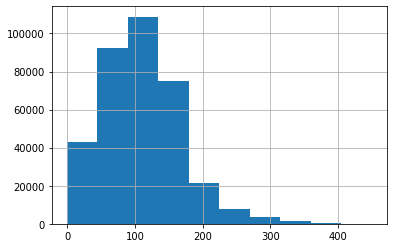

In [50]:
df[df['power']<450]['power'].hist()
df = df.query('450 > power > 50 ')

По гистограмме видно, что дальше 400 л.с. автомобилей или нет или практически нет, это можно принять за аномалии и удалить, как и автомобили в которых двигатели слабее 50 л.с. ( по очевидным причинам)

Посмотрим на аномалии в годах регистрации автомобилей

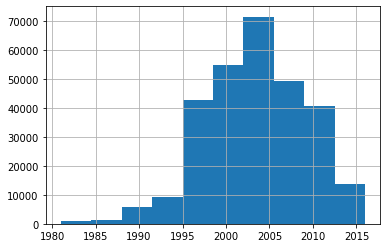

In [51]:
df[(df['registrationyear']<=2016) & (df['registrationyear']>1980) ]['registrationyear'].hist()
df= df.query('2016 > registrationyear > 1980 ')

Как видно, автомобилей старше 1980 года очень мало и этим можно пренебречь. Данные у нас только до 2020, поэтому ограничим 2020 годом.

Посмотрим на выбросы цен

<AxesSubplot:xlabel='price'>

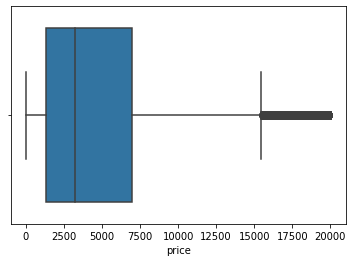

In [52]:
sns.boxplot(x=df["price"])

Как мы видим, цены больше 14к евро уже являются выбросами, их стоит удалить

In [53]:
df= df.query('14000 > price > 1500')

Проверим сколько уникальных значений в столбце регистрации по месяцам.

In [54]:
df['registrationmonth'].nunique()

13

Их 13, а месяцев 12, где-то ошибка.

In [55]:
df['registrationmonth'].value_counts()

3     18933
6     17646
5     16389
4     16192
7     15051
10    15029
11    13793
12    13705
9     13618
8     12737
1     12513
2     11891
0      6707
Name: registrationmonth, dtype: int64

Как мы видим таких нулей больше чем всех остальных цифр. Я предположу, что эти люди имели ввиду первый месяц, то есть январь, то есть этот ноль стоит заменить на единицу.

In [56]:
df[df['registrationmonth'] == 0] = 1

## Подготовка к обучению моделей

Разделим датасет на X и y тестовые и тренировочные.

In [19]:
X = df.drop(['price'],axis = 1)
y = df['price']
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,)

Для стандартизации запишем все числовые столбцы в список

In [20]:
numeric = ['power','kilometer','registrationmonth','registrationyear','postalcode']
to_dummies = ["vehicletype", "gearbox",'model','fueltype','brand','notrepaired']

Предварительно создадим пустой датафрейм и будем загружать в него получившиеся метрики на каждой модели для того чтобы потом их было удобнее сравнивать

In [21]:
models = pd.DataFrame({'model':[],'RMSE':[],'SMAPE':[]})
times = pd.DataFrame({'model':[],'learn_time':[],'predict_time':[]})

Напишем функцию использования GridSearchCV

In [22]:
def GridSearch(est,params,X_train,y_train):
    grid_search_cv_est = GridSearchCV(est,params,scoring='neg_root_mean_squared_error',cv = 5)
    grid_search_cv_est.fit(X_train,y_train)
    best_param = grid_search_cv_est.best_params_
    best_est_est = grid_search_cv_est.best_estimator_
    return best_est_est,best_param

Напишем функцию для вычисления SMAPE. Для лучшей интерпретации результата используем формулу SMAPE без коэффициента 0.5 в знаменателе, тогда SMAPE у нас будет находится в интервале от 0 % до 100 % а не от 0 % до 220%. Это удобнее интерпретировать.

In [23]:
def smape(target, predictions):
    numerator = abs(predictions - target)
    divider = (abs(target) + abs(predictions)) 
    summa = (numerator / divider).sum()

    smape = (1 / len(target)) * summa * 100
    return smape
smape_scorer = make_scorer(smape, greater_is_better=False)

## Обучение моделей

### Baseline

Возьмём за базовую модель LinearRegression и будем сравнивать все бустинги с ней.

In [24]:
for i in to_dummies:
    X_train[i] = X_train[i].astype('str')
    X_test[i] = X_test[i].astype('str')

# Объявляем scaler и OneHotEncoder() для числовых и категориальных переменных соответственно
scaler = StandardScaler() 
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
lin_reg = LinearRegression()

# Делаем pipeline для числовых переменных датасета
numerical_selector = FunctionTransformer(lambda df: df[numeric], validate=False)
numerical_preprocessor = Pipeline([("numerical_selector", numerical_selector), ("scaling", scaler)])

# Делаем pipeline для категориальных переменных датасета
dummy_selector = FunctionTransformer(lambda df: df[to_dummies], validate=False)
dummy_preprocessor = Pipeline([("dummy_selector", dummy_selector), ("ohe", ohe)])

# Объединяем созданные выше pipeline в один с помощью функции FeatureUnion и затем записываем итоговый pipeline на примере логистической регрессии
feature_union = FeatureUnion([("numerical_preprocessor", numerical_preprocessor),
("dummy_preprocessor", dummy_preprocessor)])
pipeline = Pipeline([("preprocessing", feature_union), ("modelling", lin_reg)])

# Теперь можно обучить модель
pipeline.fit(X_train,y_train)
pred = pipeline.predict(X_train)

rms = mean_squared_error(y_train, pred, squared=False)
print(f'RMSE = {rms}')

lin_smape = smape(y_train,pred)
print(f'SMAPE = {lin_smape:g}%')

new_row = {'model': ' LinearRegression','RMSE': int(rms),'SMAPE':int(lin_smape)}
models = models.append(new_row, ignore_index=True)

RMSE = 1884.9268772876692
SMAPE = 18.1508%


In [25]:
start_time = time.time()
pipeline.fit(X_train,y_train)
learn_time =(time.time() - start_time)

In [26]:
start_time = time.time()
pred = pipeline.predict(X_train)
pred_time =(time.time() - start_time)

In [27]:
new_time = {'model': ' LinearRegression',
            'learn_time': round(learn_time,2),'predict_time':round(pred_time,2)}
times = times.append(new_time, ignore_index=True)

In [28]:
res = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error' )
print(res)
res *= -1
print(f'RMSE:{res.mean()}')

[-6.98746577e+09 -4.77144042e+10 -1.90008925e+03 -3.59270785e+10
 -1.91128586e+03]
RMSE:18125790463.606434


Линейная регрессия подходит под задачи заказчика. Посмотрим на бустинги.

Теперь для кодировки категориальных столбцов используем OrdinalEncoder. One-Hot Encoding нам не подходит т.к. получается слишком много столбцов и модели очень долго обучаются.

In [29]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

for col in to_dummies:
    X_train[f'{col}_n'] = ord_enc.fit_transform(X_train[col].values.reshape(-1,1))
    X_test[f'{col}_n'] = ord_enc.transform(X_test[col].values.reshape(-1,1))
    del X_train[col]
    del X_test[col]

Теперь перейдём к более серьёзным моделям, а в частности к градиентному бустингу

# Gradient Boosting

### CatBoost

In [30]:
clf = CatBoostRegressor(loss_function= "RMSE",verbose=False,
                        learning_rate = 0.5,
                        random_state = 42)

params = {"iterations": [100,150],
          "depth": [5,8]}

In [31]:
best_clf1,best_param = GridSearch(clf,params,X_train,y_train)
print(best_param)

{'depth': 8, 'iterations': 150}


In [32]:
prediction_values_ctb = best_clf1.predict(X_train)

In [33]:
rms = mean_squared_error(y_train, prediction_values_ctb, squared=False)
print(f'RMSE = {rms}')

RMSE = 1237.3638879467555


In [34]:
ctb_smape = smape(y_train,prediction_values_ctb)
print(f'SMAPE = {ctb_smape:g}%')

SMAPE = 9.8113%


In [35]:
new_row = {'model': ' CatBoost','RMSE': int(rms),'SMAPE':int(ctb_smape)}
models = models.append(new_row, ignore_index=True)

Вывод: Градиентный бустинг с помощью библиотеки CatBoost работает сильно лучше линейной регрессии, судя по метрике RMSE.

Теперь попробуем другие библиотеки градиентного бустинга

### LightGBM

In [36]:
X_train['postalcode'] = X_train['postalcode'].astype('int')
X_test['postalcode'] = X_test['postalcode'].astype('int')

clf = ltb.LGBMRegressor(metric = 'RMSE',learning_rate = 0.5,
                        verbosity = -1,random_state = 42)

params = {"n_estimators": [100,150],
          "max_depth": [5,8]}

In [37]:
best_clf_lgt,best_param = GridSearch(clf,params,X_train,y_train)
print(best_param)

{'max_depth': 8, 'n_estimators': 150}


In [38]:
prediction_values_lgt= best_clf_lgt.predict(X_train)

In [39]:
rms = mean_squared_error(y_train, prediction_values_lgt, squared=False)
print(f'RMSE = {rms}')

RMSE = 1217.6760924888933


In [40]:
lgt_smape = smape(y_train,prediction_values_lgt)
print(f'SMAPE = {lgt_smape:g}%')

SMAPE = 12.4503%


In [41]:
new_row = {'model': ' LightGBM','RMSE': int(rms),'SMAPE':int(lgt_smape),}
models = models.append(new_row, ignore_index=True)

Вывод: библиотека LightGBM чуть лучше чем СatBoost по метрике RMSE, а вот SMAPE почему-то хуже, но она нас не так интересует.

### XGBoost

In [42]:
clf = xg.XGBRegressor(objective ='reg:squarederror', seed = 42,
                  eval_metric='rmse', learning_rate= 0.5)


params = {"n_estimators": [100,150],
          "max_depth": [5,8]}

In [43]:
best_clf1,best_param = GridSearch(clf,params,X_train,y_train)
print(best_param)

{'max_depth': 5, 'n_estimators': 150}


In [44]:
prediction_values_xgb= best_clf1.predict(X_train)

In [45]:
rms = mean_squared_error(y_train, prediction_values_xgb, squared=False)
print(f'RMSE = {rms}')

RMSE = 1249.7040846221437


In [46]:
xgb_smape = smape(y_train,prediction_values_xgb)
print(f'SMAPE = {xgb_smape:g}%')

SMAPE = 12.5996%


In [47]:
new_row = {'model': ' XGBoost','RMSE': int(rms),'SMAPE':int(xgb_smape)}
models = models.append(new_row, ignore_index=True)

Вывод: XGBoost хуже и LightGBM и CatBoost.

## Анализ моделей

Проведём проверку на адекватность

In [48]:
dummy_regr = DummyRegressor(strategy="mean")

In [49]:
dummy_regr.fit(X_train, y_train)

DummyRegressor()

In [50]:
prediction_values_dum = dummy_regr.predict(X_train)

In [51]:
rms = mean_squared_error(y_train, prediction_values_dum, squared=False)
print(rms)

3393.8846003295325


In [52]:
dum_smape = smape(y_train,prediction_values_dum)
print(f'SMAPE = {dum_smape:g}%')

SMAPE = 28.0663%


In [53]:
new_row = {'model': ' DummyRegressor','RMSE': int(rms),'SMAPE':int(dum_smape)}
models = models.append(new_row, ignore_index=True)

Вывод: Как мы видим, DummyRegressor предсказал сильно худшие значения, значит наши модели адекватны.

Отсортируем список со знчениями моделей по возрастанию

In [54]:
models = models.sort_values(ascending = True, by = 'RMSE')

In [55]:
models

,model,RMSE,SMAPE
2,LightGBM,1217.0,12.0
1,CatBoost,1237.0,9.0
3,XGBoost,1249.0,12.0
0,LinearRegression,1884.0,18.0
4,DummyRegressor,3393.0,28.0


## Замер времени

## CatBoost

In [56]:
clf = CatBoostRegressor(loss_function= "RMSE",verbose=False,
                        learning_rate = 0.5,
                        depth = 8,
                        iterations = 150,
                        random_state = 42)

In [57]:
start_time = time.time()
clf.fit(X_train,y_train)
learn_time =(time.time() - start_time)

In [58]:
start_time = time.time()
pred = clf.predict(X_train)
pred_time =(time.time() - start_time)

In [59]:
new_time = {'model': ' CatBoost',
            'learn_time': round(learn_time,2),'predict_time':round(pred_time,2)}
times = times.append(new_time, ignore_index=True)

## LightGBM

In [60]:
clf = ltb.LGBMRegressor(metric = 'RMSE',
                        n_estimators = 150,
                        max_depth = 8,
                        learning_rate = 0.5,
                        verbosity = -1,
                        random_state = 42)

In [61]:
start_time = time.time()
clf.fit(X_train,y_train)
learn_time =(time.time() - start_time)

In [62]:
start_time = time.time()
pred = clf.predict(X_train)
pred_time =(time.time() - start_time)

In [63]:
new_time = {'model': ' LightGBM',
            'learn_time': round(learn_time,2),'predict_time':round(pred_time,2)}
times = times.append(new_time, ignore_index=True)

## XGBoost

In [64]:
clf = xg.XGBRegressor(objective ='reg:squarederror',
                      n_estimators = 150,
                      max_depth = 8,
                      seed = 42,
                      eval_metric='rmse',
                      learning_rate= 0.5)

In [65]:
start_time = time.time()
clf.fit(X_train,y_train)
learn_time =(time.time() - start_time)

In [66]:
start_time = time.time()
pred = clf.predict(X_train)
pred_time =(time.time() - start_time)

In [67]:
new_time = {'model': ' XGBoost',
            'learn_time': round(learn_time,2),'predict_time':round(pred_time,2)}
times = times.append(new_time, ignore_index=True)

In [68]:
times

,model,learn_time,predict_time
0,LinearRegression,3.84,0.64
1,CatBoost,2.13,0.02
2,LightGBM,0.52,0.21
3,XGBoost,5.45,0.14


In [69]:
models

,model,RMSE,SMAPE
2,LightGBM,1217.0,12.0
1,CatBoost,1237.0,9.0
3,XGBoost,1249.0,12.0
0,LinearRegression,1884.0,18.0
4,DummyRegressor,3393.0,28.0


In [70]:
models.merge(times,on='model',how='inner')

,model,RMSE,SMAPE,learn_time,predict_time
0,LightGBM,1217.0,12.0,0.52,0.21
1,CatBoost,1237.0,9.0,2.13,0.02
2,XGBoost,1249.0,12.0,5.45,0.14
3,LinearRegression,1884.0,18.0,3.84,0.64


## Тестирование модели

In [71]:
prediction_values_lgt_test = best_clf_lgt.predict(X_test)

In [72]:
rms = mean_squared_error(y_test, prediction_values_lgt_test, squared=False)
print(f'RMSE = {rms}')

RMSE = 1366.1916809520408


## Общий вывод

Подводя итоги, можно сказать что в данном случае LightGBM выиграл у всех моделей. Он самый быстрообучаемый и самый точный, однако скорость предсказания у него ниже чем у CatBoost'a. XGBoost очень долго обучается, но предсказывает точнее всех и по скорости на втором месте после CatBoost'a. Про линейную регрессию говорить нечего, она тут сильно проиграла. В общем, можно сказать что все 3 библиотеки реализации градиентного бустинга хороши в своём. Если нужен максимально точный прогноз и неважно затраченое на это время, то стоит выбрать XGBoost, если необходима большая скорость обучения и не важна скорость предсказания, то это LightGBM, если же необходимо средняя скорость обучения, но очень высокая скорость предсказания это CatBoost. В зависимости от задачи каждая из этих библиотек сможет помочь.